In [1]:
import numpy as np
import matplotlib.pyplot as plt
from particles import kalman

In [2]:
# first define the linear gaussian model
# dimensions
dx = 4
dy = 2

# initial distribution of X0 ~ N(mu0,Sigma0)
mu0 = np.zeros(dx)
Sigma0 = np.eye(dx)
almost_zero = 1e-15

# transition for Xt
def construct_ssm(rho, sigma_X, sigma_Y):
    # transition matrix
    F = np.diag([1, 1, rho, rho])
    F[0,2] = 1
    F[1,3] = 1

    # covariance matrix for Xt
    SigmaX = np.diag([almost_zero, almost_zero, sigma_X**2, sigma_X**2])

    # observation matrix
    G = np.zeros([dy, dx])
    G[0,0] = 1
    G[1,1] = 1

    # observation covariance matrix
    SigmaY = np.diag([sigma_Y**2, sigma_Y**2])

    # define my linear gaussian model state space model (SSM) for tracking
    ssm = kalman.MVLinearGauss(F=F, G=G, covX=SigmaX, covY=SigmaY, mu0=mu0, cov0=Sigma0)

    return ssm


In [6]:
# construct model with some parameter values
ssm = construct_ssm(rho=0.99, sigma_X=1, sigma_Y=20)


In [7]:
# simulate data from the model
T = 500
states, obs = ssm.simulate(T=T)

In [8]:
print(type(states))
print(len(states))

print(type(obs))
print(len(obs))

<class 'list'>
500
<class 'list'>
500


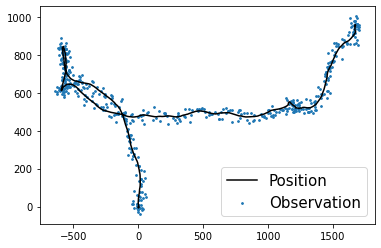

In [14]:
# plot the simulated data
X1 = [x[0,0] for x in states]
X2 = [x[0,1] for x in states]
Y1 = [y[0,0] for y in obs]
Y2 = [y[0,1] for y in obs]

plt.figure()
plt.plot(X1, X2, 'k-')
plt.scatter(Y1, Y2, s=3)
plt.legend(["Position", "Observation"], fontsize=15)



In [15]:
# Kalman filtering 

# just instantiates the class for Kalman filtering
kf = kalman.Kalman(ssm=ssm, data=obs)

# run Kalman filter
kf.filter()


In [21]:
# results 
print(type(kf.filt))
print(len(kf.filt))
print(kf.filt[0])

<class 'list'>
500
MeanAndCov(mean=array([[-0.07163543,  0.04674642,  0.        ,  0.        ]]), cov=array([[0.99750623, 0.        , 0.        , 0.        ],
       [0.        , 0.99750623, 0.        , 0.        ],
       [0.        , 0.        , 1.        , 0.        ],
       [0.        , 0.        , 0.        , 1.        ]]))


In [24]:
# mean vector at time 0
print(kf.filt[0].mean)

# covariance matrix at time 0 
print(kf.filt[0].cov)

[[-0.07163543  0.04674642  0.          0.        ]]
[[0.99750623 0.         0.         0.        ]
 [0.         0.99750623 0.         0.        ]
 [0.         0.         1.         0.        ]
 [0.         0.         0.         1.        ]]


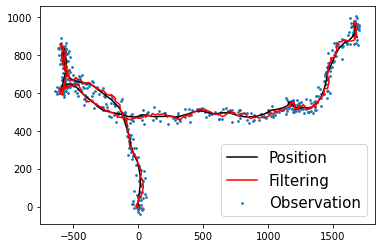

In [39]:
# extracts the filtering means
X1_filtering = [filtering.mean[0,0] for filtering in kf.filt]
X2_filtering = [filtering.mean[0,1] for filtering in kf.filt]


plt.figure()
plt.plot(X1, X2, 'k-')
plt.plot(X1_filtering, X2_filtering, 'r-')
plt.scatter(Y1, Y2, s=3)
plt.legend(["Position", "Filtering", "Observation"], fontsize=15)

In [48]:
# incremental log-likelihood values
print(type(kf.logpyt))
print(len(kf.logpyt))
print(kf.logpyt[0])

# log-likelihood value
print(np.sum(kf.logpyt))

<class 'list'>
500
[-9.11468194]
-4623.2047091023305


In [41]:
# run Kalman smoothing
kf.smoother()

# results 
print(type(kf.smth))
print(len(kf.smth))

# smoothing mean at time 0
print(kf.smth[0].mean)

# smoothing cov at time 0
print(kf.smth[0].cov)


<class 'list'>
500
[[ 0.03865447 -0.19219018 -0.08546917 -0.38171473]]
[[ 0.98436914  0.         -0.04219801  0.        ]
 [ 0.          0.98436914  0.         -0.04219801]
 [-0.04219801  0.          0.7368777   0.        ]
 [ 0.         -0.04219801  0.          0.7368777 ]]


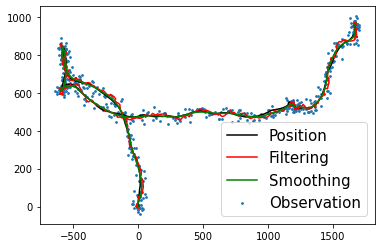

In [43]:
# extracts the smoothing means
X1_smoothing = [smoothing.mean[0,0] for smoothing in kf.smth]
X2_smoothing = [smoothing.mean[0,1] for smoothing in kf.smth]


# smoothing means are "smoother" than the filtering means
plt.figure()
plt.plot(X1, X2, 'k-')
plt.plot(X1_filtering, X2_filtering, 'r-')
plt.plot(X1_smoothing, X2_smoothing, 'g-')
plt.scatter(Y1, Y2, s=3)
plt.legend(["Position", "Filtering", "Smoothing", "Observation"], fontsize=15)



In [49]:
# learn parameters using maximum likelihood
def loglikelihood(theta):
    # get parameters
    rho = theta[0]
    sigma_X = theta[1]
    sigma_Y = theta[2]

    # construct state space model
    ssm = construct_ssm(rho, sigma_X, sigma_Y)

    # run Kalman filtering to evaluate the log-likelihood
    kf = kalman.Kalman(ssm=ssm, data=obs)
    kf.filter()

    # return loglikelihood using sum
    return np.sum(kf.logpyt)


In [54]:
from scipy.optimize import minimize
theta0 = [1, 2, 10]
output = minimize(lambda theta: -loglikelihood(theta), theta0)


In [55]:
# maximum likelihood estimator 
print("MLE", output.x)

# true parameters
print("True parameters:")
print(["rho", 0.99, "sigma_X", 1, "sigma_Y", 20])

MLE [ 0.98677444  1.05542989 21.13449249]
True parameters:
['rho', 0.99, 'sigma_X', 1, 'sigma_Y', 20]
